# KS-Test for Concept Drift from the  paper: Reactive Soft Prototype Computing for Concept Drift Streams
## https://arxiv.org/abs/2007.05432

In [1]:
from random import sample
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt

### Generate data with concept drift 

### Dimension 1 data

In [2]:
y1 = []
x1 = np.linspace(0,100,1000)

drift_cut = 300
for i,j in enumerate(x1):
    if i < drift_cut:
        y1.append(np.random.normal(2,.5))
    else:
        y1.append(np.sin(j/10)+np.random.normal(j/10,.8)+5)

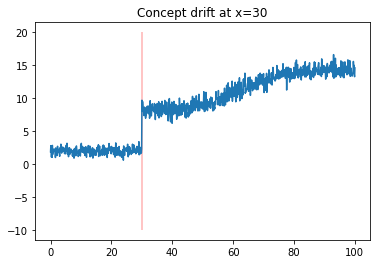

In [3]:
plt.title("Concept drift at x=30")
plt.plot(x1,y1)
plt.vlines(30,-10,20,color="red",alpha=.3)

### Dimension 2 data

In [4]:
y2 = []
x2 = np.linspace(0,100,1000)

drift_cut = 300
for i,j in enumerate(x2):
    y2.append(np.random.normal(0,.1))

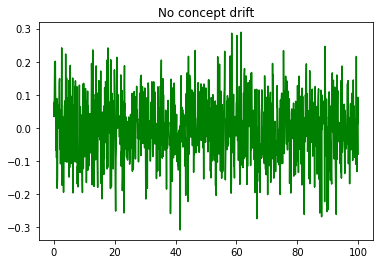

In [5]:
plt.title("No concept drift")
plt.plot(x2,y2,color="green")

### Join data

In [6]:
y = np.column_stack((y1,y2))

## KS-Test Class

In [7]:
class KS:
    """ Class to be used for KS-test """
    def __init__(self, n_max: int, r: int, dim: int):
        self.n_max = n_max
        self.r = r
        self.dim = dim
        self.window = []
        self.uni_window = []
        self.new_window = []
        self.p_vals = []
        
    def push(self, data: list):
        """ Adds value to window """
        if len(self.window) < self.n_max:
            self.window.insert(0, data) 
        else:
            self.window.insert(0, data) 
            self.pop()
            
    def pop(self):
        """ Removes oldest value from window """
        _ = self.window.pop()
        
    def buildTestWindow(self):
        """ Place data into windows used for KS test """
        if len(self.window) < self.n_max:
            print("Not enough samples in window")
        else:
            self.new_window, self.uni_window = [], []
            self.new_window = self.window[-self.r:]
            self.uni_window = [self.window[i] for i in sample(range(self.n_max-self.r), self.r)]
            
    def test(self, alpha: float = .05) -> bool:
        """ Run test to check for concept drift """
        self.buildTestWindow()
        alpha_correct = alpha/self.dim
        all_p_vals = []
        for i in range(self.dim):
            uni_data = [self.uni_window[j][i] for j in range(len(self.uni_window))]
            new_data = [self.new_window[j][i] for j in range(len(self.new_window))]
            _, p_val = stats.ks_2samp(uni_data, new_data)
            all_p_vals.append(p_val)
        self.p_vals.append(all_p_vals)
        if any(i < alpha_correct for i in all_p_vals):
            return True, all_p_vals
        else:
            return False, _
    
    def getPvals(self) -> list:
        """ Return all stored p-vals from test """
        vals = []
        for i in range(self.dim):
            p = [self.p_vals[j][i] for j in range(len(self.p_vals))]
            vals.append(p)
        return vals

## Run test

In [8]:
# Declare KS test object
hTest = KS(100,30,2)

# Simulate stream of data and run KS object
for i in range(350):
    hTest.push(y[i,:].tolist())
    if i > 100:
        r, p_vals = hTest.test()
        if r == True:
            print("Concept Drift detected: {}, {}".format(i,p_vals))

Concept Drift detected: 222, [0.015643390496754332, 0.8079631540901643]
Concept Drift detected: 261, [0.5940706297759378, 0.015643390496754332]
Concept Drift detected: 279, [0.015643390496754332, 0.9578462903438838]
Concept Drift detected: 306, [0.006548396368058784, 0.9988393756362763]
Concept Drift detected: 315, [0.0025300622362698397, 0.8079631540901643]
Concept Drift detected: 316, [0.0008995776840176799, 0.9578462903438838]
Concept Drift detected: 318, [0.0025300622362698397, 0.9578462903438838]
Concept Drift detected: 322, [0.0008995776840176799, 0.5940706297759378]
Concept Drift detected: 323, [0.015643390496754332, 0.23907300248018645]
Concept Drift detected: 324, [8.737803591291227e-05, 0.9578462903438838]
Concept Drift detected: 325, [0.0025300622362698397, 0.9578462903438838]
Concept Drift detected: 326, [0.006548396368058784, 0.8079631540901643]
Concept Drift detected: 327, [0.0025300622362698397, 0.39294501397971776]
Concept Drift detected: 328, [2.366488472641374e-05, 0.

## Plot trace of p-vals

Text(0.5, 1.0, 'Alpha value of 0.025')

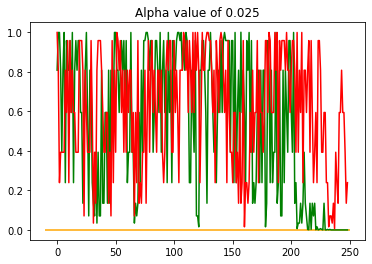

In [9]:
p_vals = hTest.getPvals()

plt.plot(range(len(p_vals[0][:])),p_vals[0][:],color="green")
plt.plot(range(len(p_vals[1][:])),p_vals[1][:],color="red")
plt.hlines(.05/30,-10,250,color="orange")
plt.title("Alpha value of {}".format(.05/2))